In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import re
import os

In [2]:
image_datas = glob('./korean_foods/*/*.jpg')
class_name = ["kalguksu", "champon", "kimbap", "bibimbap", "bossam",
                "kimchi", "radish_kimchi", "dak_galbi", "kimchi_fried_rice", "bulgogi"]
dic = {"kalguksu":0, "champon":1, "kimbap":2, "bibimbap":3, "bossam":4,
                "kimchi":5, "radish_kimchi":6, "dak_galbi":7, "kimchi_fried_rice":8, "bulgogi":9}

In [3]:
X = []
Y = []
for imagename in image_datas:
    image = Image.open(imagename)
    image = image.resize((128, 128))
    image = np.array(image)
    X.append(image)
    label = imagename.split('\\')[2].replace('.jpg','').replace(' ','')
    label = re.sub(r"[0-9]", "", label)
    label = label[:-1]
    label = dic[label]
    Y.append(label)

In [4]:
X = np.array(X)    
Y = np.array(Y)  

In [5]:
train_images, test_images, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, 
                                                    shuffle=True, random_state=44)

train_labels = train_labels[..., tf.newaxis]
test_labels = test_labels[..., tf.newaxis]

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((866, 128, 128, 3), (866, 1), (217, 128, 128, 3), (217, 1))

In [6]:
## training set의 각 class 별 image 수 확인
unique, counts = np.unique(np.reshape(train_labels, (866,)), axis=-1, return_counts=True)
dict(zip(unique, counts))

{0: 93, 1: 81, 2: 86, 3: 86, 4: 85, 5: 82, 6: 90, 7: 93, 8: 83, 9: 87}

In [7]:
## test set의 각 class 별 image 수 확인
unique, counts = np.unique(np.reshape(test_labels, (217,)), axis=-1, return_counts=True)
dict(zip(unique, counts))

{0: 15, 1: 15, 2: 19, 3: 30, 4: 23, 5: 20, 6: 26, 7: 28, 8: 17, 9: 24}

In [8]:
N_TRAIN = train_images.shape[0]
N_TEST = test_images.shape[0]

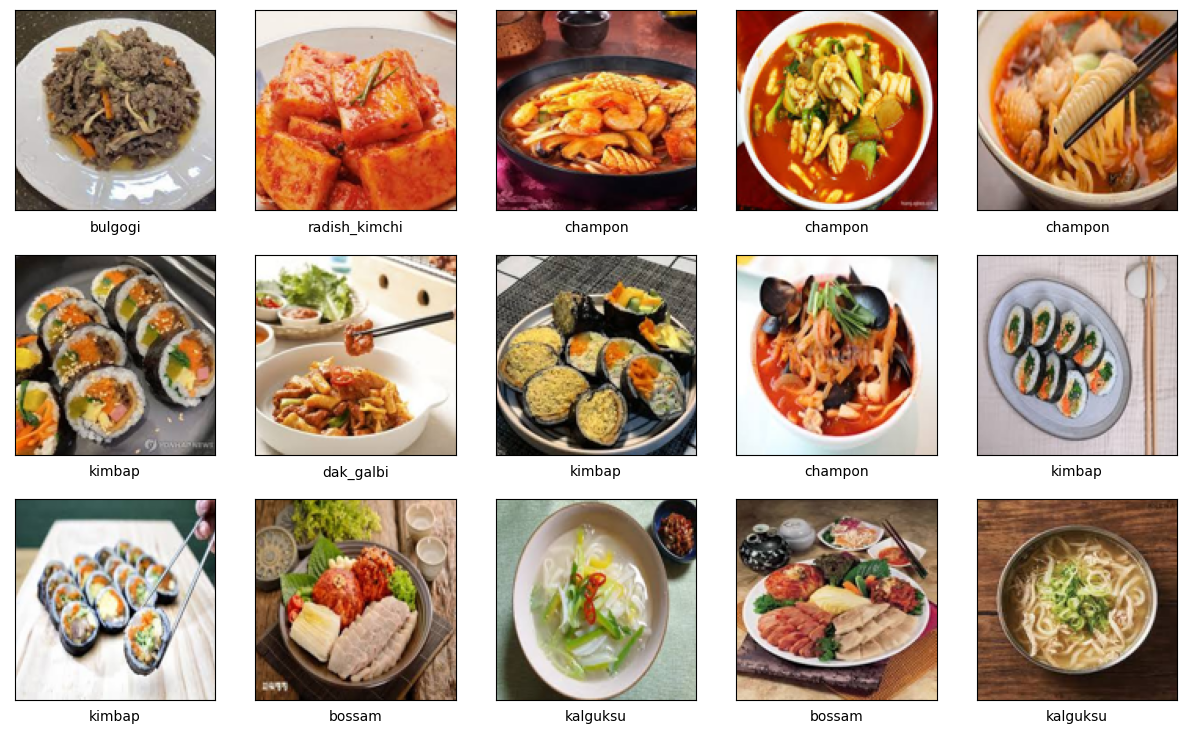

In [9]:
## Data 확인
plt.figure(figsize=(15,9))
for i in range(15):
    img_idx = np.random.randint(0, 875)
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[img_idx])
    plt.xlabel(class_name[train_labels[img_idx][0]])


In [10]:
# pixel값을 0~1사이 범위로 조정
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

# label을 onehot-encoding
train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)

In [11]:
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(866, 128, 128, 3) (866, 10)
(217, 128, 128, 3) (217, 10)


In [12]:
## Hyper-parameters
learning_rate = 0.0001
N_EPOCHS = 50
N_BATCH = 40
N_CLASS = 10

In [13]:
## dataset 구성    
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=875).batch(N_BATCH).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(
				N_BATCH)

In [14]:
# Sequential API를 사용하여 model 구성
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, 
                                  activation='relu', padding='SAME', 
                                  input_shape=(128, 128, 3)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, 
                                  activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, 
                                  activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [15]:
## Create model, compile & summary
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0

In [16]:
## Parameters for training
steps_per_epoch = N_TRAIN//N_BATCH
validation_steps = N_TEST//N_BATCH
print(steps_per_epoch, validation_steps)

21 5


In [17]:
## Training
history = model.fit(train_dataset, epochs=N_EPOCHS, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Epoch 1/50
21/21 [==============================] - 11s 482ms/step - loss: 2.3130 - accuracy: 0.1345 - val_loss: 2.2664 - val_accuracy: 0.1900
Epoch 2/50
21/21 [==============================] - 10s 497ms/step - loss: 2.1919 - accuracy: 0.2191 - val_loss: 2.1236 - val_accuracy: 0.2250
Epoch 3/50
21/21 [==============================] - 10s 489ms/step - loss: 2.0316 - accuracy: 0.2494 - val_loss: 1.9314 - val_accuracy: 0.2700
Epoch 4/50
21/21 [==============================] - 10s 499ms/step - loss: 1.8751 - accuracy: 0.3063 - val_loss: 1.8015 - val_accuracy: 0.3400
Epoch 5/50
21/21 [==============================] - 11s 527ms/step - loss: 1.6995 - accuracy: 0.3923 - val_loss: 1.7056 - val_accuracy: 0.3750
Epoch 6/50
21/21 [==============================] - 11s 505ms/step - loss: 1.5571 - accuracy: 0.4600 - val_loss: 1.6044 - val_accuracy: 0.4250
Epoch 7/50
21/21 [==============================] - 10s 501ms/step - loss: 1.5110 - accuracy: 0.4758 - val_loss: 1.5416 - val_accuracy: 0.4450

In [18]:
model.evaluate(test_dataset)

6/6 [==============================] - 1s 98ms/step - loss: 1.9054 - accuracy: 0.4885


[1.905399203300476, 0.48847925662994385]

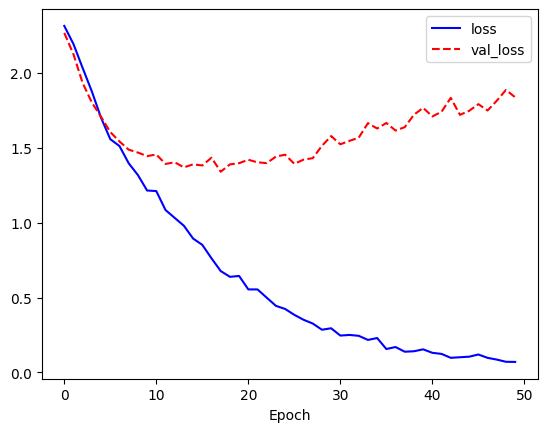

In [19]:
## Plot losses
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

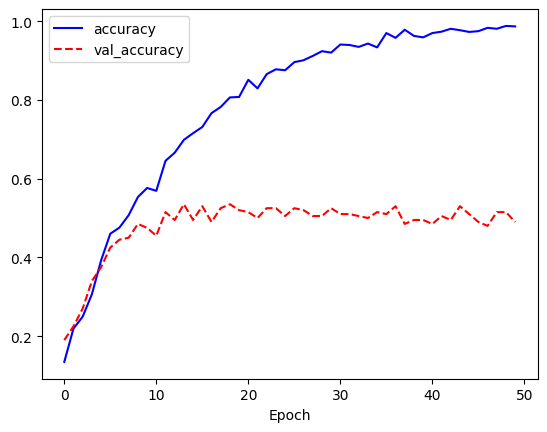

In [20]:
## Plot accuracy
plt.plot(history.history['accuracy'], 'b-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [21]:
## 결과 확인
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_name[predicted_label],
                                100*np.max(predictions_array),
                                class_name[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    #plt.xticks([])
    plt.xticks(range(N_CLASS), class_name, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(N_CLASS), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

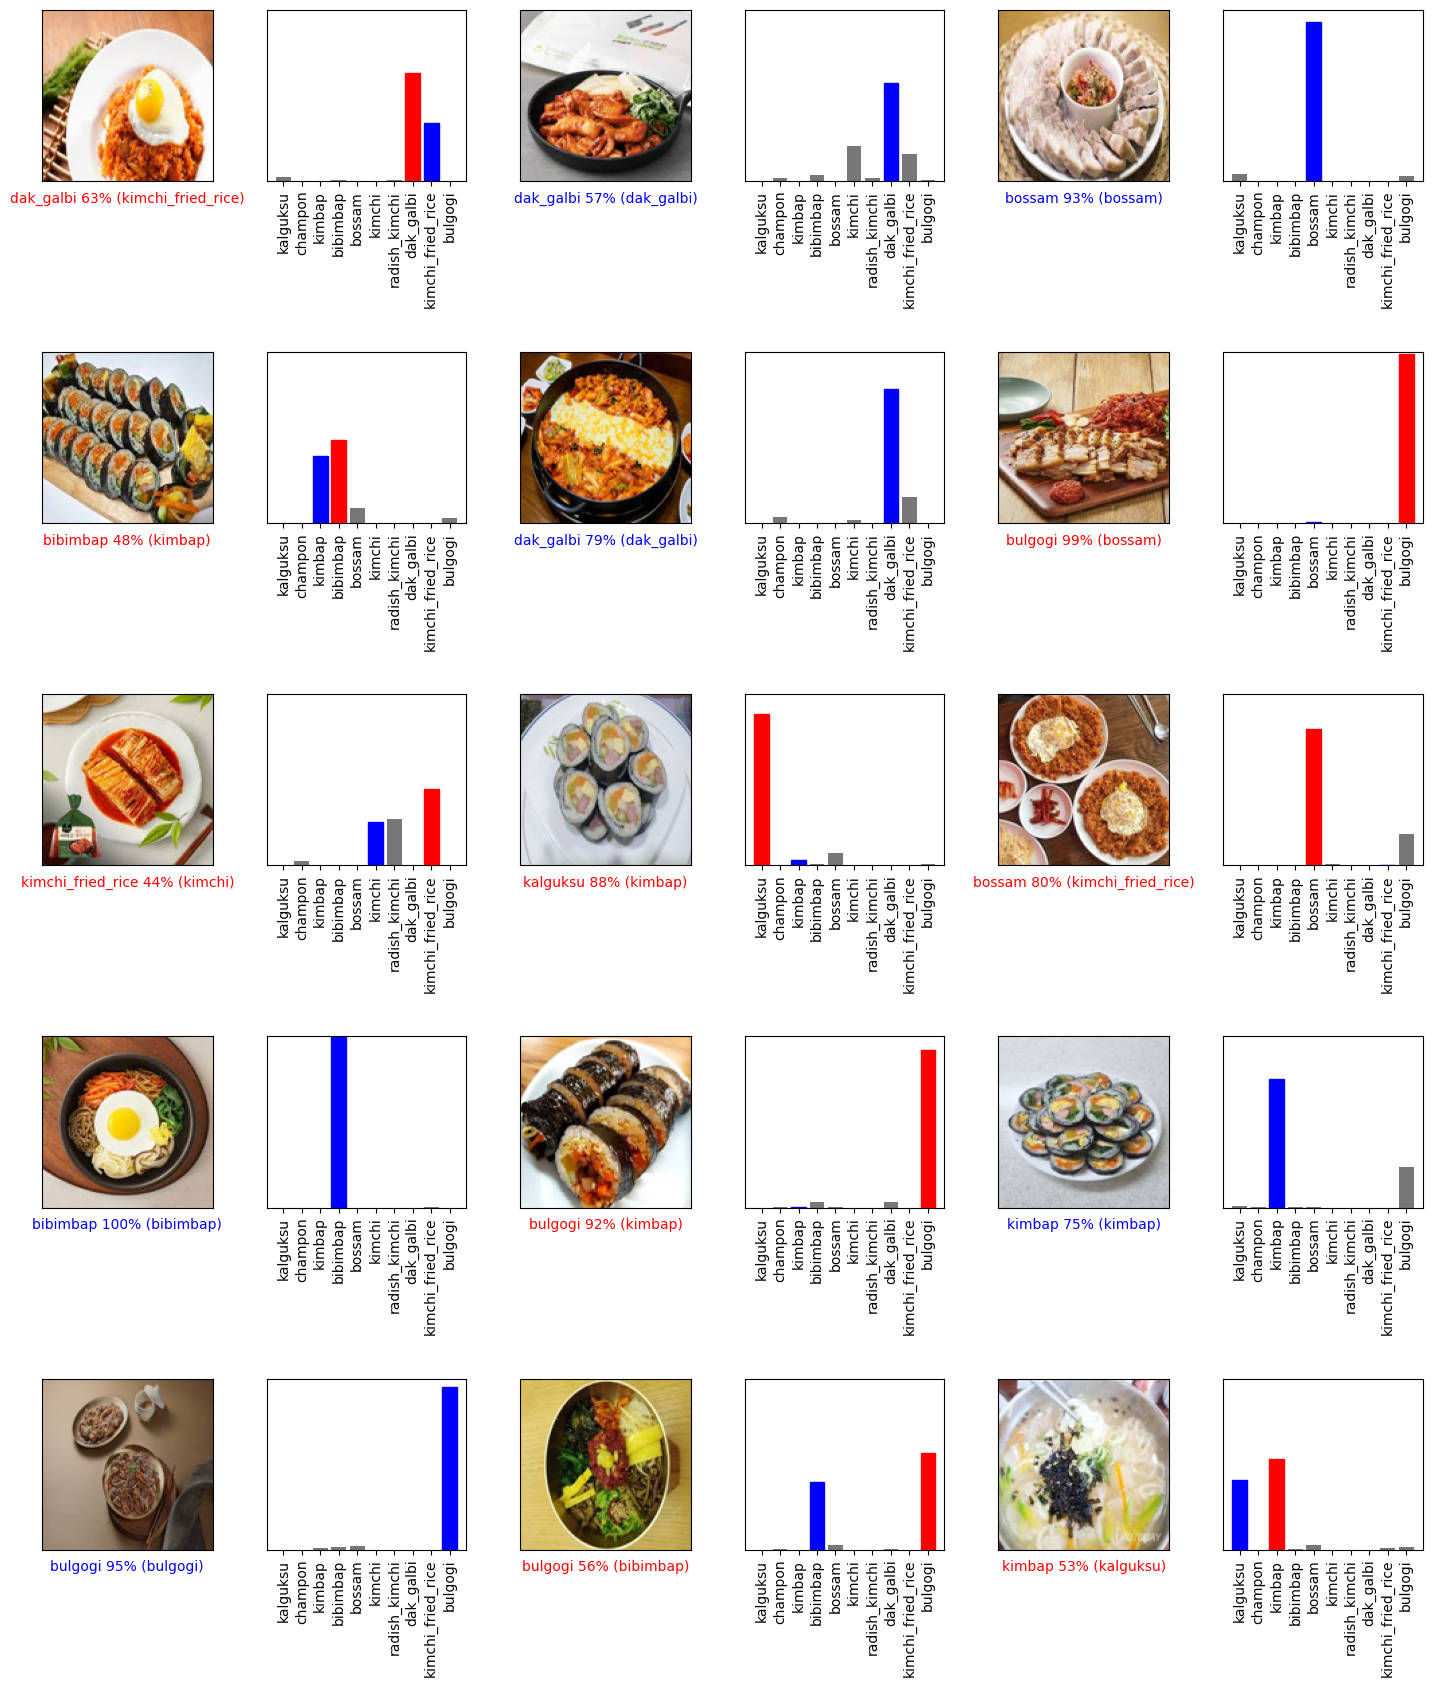

In [29]:
rnd_idx = np.random.randint(1, N_TEST//N_BATCH)
img_cnt = 0
for images, labels in test_dataset:
    img_cnt += 1
    if img_cnt != rnd_idx:
        continue
    predictions = model(images, training=False)
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    labels = tf.argmax(labels, axis=-1)
    plt.figure(figsize=(3*2*num_cols, 4*num_rows))
    plt.subplots_adjust(hspace=1.0)
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions.numpy(), labels.numpy())        
    break

In [23]:
cur_dir = os.getcwd() #현재 작업디렉토리
ckpt_dir = 'checkpoints' #weight를 저장할 디렉토리
file_name = 'korean_cnn_weights.h5' #저장파일명

dir = os.path.join(cur_dir, ckpt_dir)
os.makedirs(dir, exist_ok=True)

file_path = os.path.join(dir, file_name)

In [24]:
model.save(file_path)

In [31]:
food_kcal = {"kalguksu":420, "champon":688, "kimbap":485, "bibimbap":586, "bossam":1296,
                "kimchi":29, "radish_kimchi":19, "dak_galbi":669, "kimchi_fried_rice":530, "bulgogi":471}

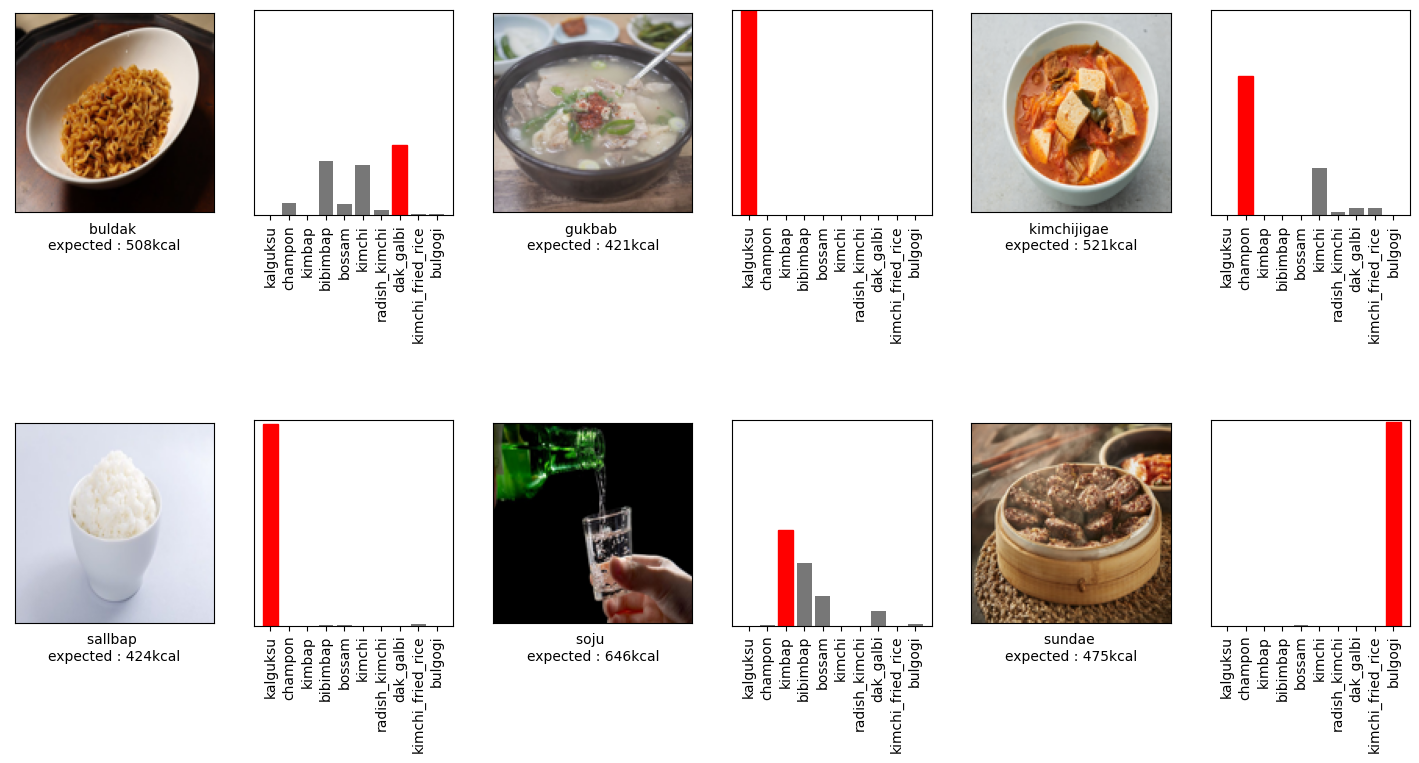

In [89]:
testimg_datas = glob('./test_img/*.jpg')

X2 = []
Y2 = []
for testimgname in testimg_datas:
    image = Image.open(testimgname)
    image = image.resize((128, 128))
    image = np.array(image)
    X2.append(image)
    label = testimgname.split('\\')[1].replace('.jpg','').replace(' ','')
    Y2.append(label)

X2 = np.array(X2)  

# pixel값을 0~1사이 범위로 조정
X2 = X2.astype(np.float32) / 255.

predictions = model(X2, training=False)

num_rows = 2
num_cols = 3

def calculate_kcal(predict_array):
    kcal = 0
    for i in range(10):
        kcal += predict_array[i] * food_kcal[class_name[i]]
    return kcal


plt.figure(figsize=(3*2*num_cols, 4*num_rows))
plt.subplots_adjust(hspace=1.0)

for i in range(len(X2)):
    # print(Y2[i])
    # print(predictions.numpy()[i])
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X2[i])
    plt.xlabel("{} \nexpected : {:2.0f}kcal".format(Y2[i], calculate_kcal(predictions.numpy()[i])))
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plt.grid(False)    
    plt.xticks(range(N_CLASS), class_name, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(N_CLASS), predictions.numpy()[i], color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions.numpy()[i])
    thisplot[predicted_label].set_color('red')
    